# Úkol č. 3 - Segmentace zákazníků e-shopu
**Deadline úkolu je uveden na [course pages](https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html).**

Jednou z důležitých aplikací shlukování je **segmentace zákazníků** (angl. **customer segmentation**). 

Předpokládejme, že máme následující obchodní údaje o prodejích (resp. nákupech z pohledu zákazníků):
TransactionID - ID nákupu,
CustomerID - ID zákazníka, 
Date - datum nákupu, 
Total - celková cena nákupu.

Chceme najít segmenty zákazníků, kteří se chovají podobně. K tomu je dobré informace z jednotlivých nákupů pro individuální zákazníky agregovat. Tj. získat pro každého zákazníka jeden řádek.

Populárním přístupem je **RFM**, což znamená:

- **R**ecency: Počet dnů od posledního nákupu (poslední datum v datasetu pro daného zákazníka).
- **F**requency: Počet nákupů. Občas se vynechávají zákazníci s jediným nákupem. Pro jednoduchost je zde ale necháme.
- **M**onetary: Celková suma, kterou daný zákazník utratil.

## Zdroj dat
Budeme pracovat s daty z jednoho (skoro) vymyšleného eshopu, která jsou v přiloženém souboru `eshop.csv`.

## Pokyny k vypracování

Ve všech bodech zadání uvažujte aktuální datum jako datum poslední transakce (19. 12. 2015), nikoliv dnešek. Tváříme se, že jde o aktuální data.

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
- Vytvořte `rfm` data frame, kde každý řádek odpovídá jednomu zákazníkovi a sloupce (příznaky) jsou uvedené výše.
- Pomocí algoritmu `K-means` proveďte shlukování. Nějakým způsobem také odhadněte nejlepší počet shluků (podrobně vysvětlete).
- Zabývejte se vlivem přeškálování dat (standardizace příznaků). Tj. určete, zda je přeškálování vhodné, a proveďte ho.
- Interpretujte jednotlivé shluky. Použijte získané shluky k odlišení "superstar" zákazníků (vysoká monetary, vysoká frequency a nízká recency) od nezajímavých  zákazníků (vysoká recency, nízká frequency, nízká monetary).

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
- (až +4 body) Proveďte analýzu vytvořených shluků pomocí metody silhouette (https://en.wikipedia.org/wiki/Silhouette_(clustering)).
- (až +4 body) Zkuste provést to samé s modifikovanou verzí **RFM**, kde Recency = "maximum počtu měsíců od posledního nákupu a čísla 1", Frequency = "maximum počtu nákupů daného zákazníka v posledních 12 měsících a čísla 1", Monetary = "Nejvyšší hodnota nákupu daného zákazníka". Porovnejte s původním přístupem.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook.
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni.

# -----------------------------------------------------------------------------------------------------------

## Imports

In [564]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing

import warnings
#-------------------------------------------------------------------------------------------------------------------------#
seed = 666
warnings.filterwarnings('ignore')

## Preprocess data

In [565]:
data = pd.read_csv('eshop.csv')
data.head(5)

,Customer ID,Date,Subtotal,Country
0,34,6/21/2007,86.0,Czech Republic
1,38,6/27/2007,38.4,Czech Republic
2,47,7/2/2007,53.5,Slovakia
3,61,7/14/2007,7.0,Czech Republic
4,78,7/21/2007,55.5,Czech Republic


In [566]:
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', ascending=False, inplace=True)

last_transaction = data.iloc[0]['Date']
print(f'Last recorded transaction took place on: {last_transaction}')

Last recorded transaction took place on: 2015-12-19 00:00:00


In [567]:
rfm = data.drop(['Subtotal', 'Country'], axis=1)

### Recency

In [568]:
rfm = rfm.drop_duplicates(subset='Customer ID', keep='first')
rfm['Recency'] = rfm['Date'].apply(lambda x: (last_transaction - x).days)
#rfm['Recency'] = rfm['Date'].apply(lambda x: math.log((last_transaction - x).days + 1))
rfm = rfm.drop(['Date'], axis=1)

### Frequency

In [569]:
counts = data.groupby('Customer ID').count()['Date'].rename('Frequency')
rfm = rfm.merge(counts, how='left', on='Customer ID')

### Monetary

In [570]:
totals = data.groupby('Customer ID')['Subtotal'].sum().rename('Monetary')#.apply(math.log)
rfm = rfm.merge(totals, how='left', on='Customer ID')
rfm.sort_values('Monetary')

,Customer ID,Recency,Frequency,Monetary
4453,11428,703,1,1.18
7429,8037,1237,1,1.64
11451,2867,2075,1,1.68
11775,2398,2175,1,1.80
9475,5442,1650,1,2.05
...,...,...,...,...
1853,12294,240,3,7851.53
2440,13481,341,2,8739.21
2406,9639,337,24,8945.18
5912,6544,969,7,11427.92


In [571]:
# Function to display several tables in a row next to each other (works in Jupyter, not on Gitlab)
# source: https://www.xspdf.com/help/50899244.html

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+= df.to_html() + '&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp'
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [572]:
display_side_by_side(rfm.sort_values('Recency').tail(15)[['Customer ID', 'Recency']],
                     rfm.sort_values('Frequency').tail(15)[['Customer ID', 'Frequency']],
                     rfm.sort_values('Monetary').tail(15)[['Customer ID', 'Monetary']])

,Customer ID,Recency
12814,166,3013
12815,30,3025
12816,131,3033
12817,96,3042
12818,67,3043
12819,9,3050
12820,62,3054
12821,82,3069
12822,48,3069
12823,78,3073


## K-Means Clustering

In [573]:
rfm_km = rfm.drop(['Customer ID'], axis=1)

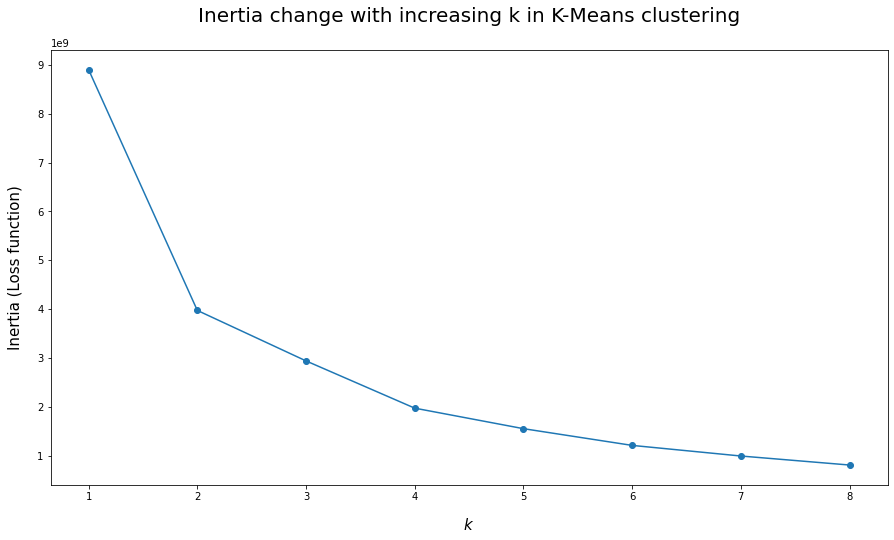

In [574]:
k_cnt = 8

inertias = np.zeros(k_cnt)
for k in range(k_cnt):
    kmeans = KMeans(n_clusters=k+1, random_state = 1)
    kmeans.fit(rfm_km)
    inertias[k] = kmeans.inertia_

plt.figure(figsize=(15,8))
plt.title('Inertia change with increasing k in K-Means clustering', fontsize=20, y=1.05)
plt.xlabel('$k$', fontsize=15, labelpad=15)
plt.ylabel('Inertia (Loss function)', fontsize=15, labelpad=15)
plt.plot(range(1, k_cnt + 1), iy, 'o-')
plt.show()

In [575]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=seed).fit(rfm_km)

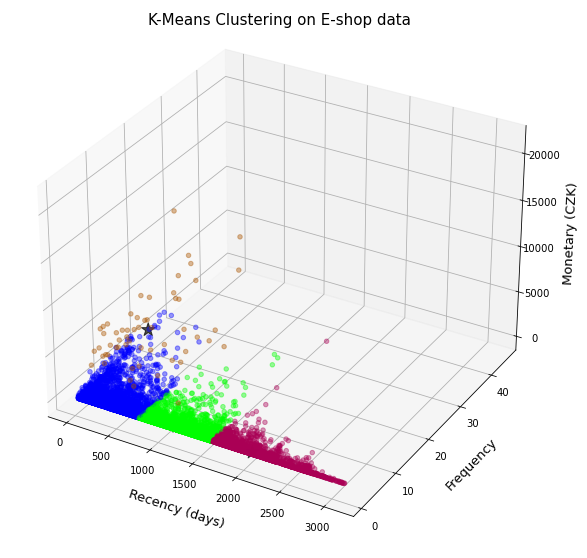

In [576]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rfm_km['Recency'], rfm_km['Frequency'], rfm_km['Monetary'], c=kmeans.labels_, cmap='brg', alpha=0.4)
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2],
            c='black', alpha=0.7, s=200, marker='*')

ax.set_title('K-Means Clustering on E-shop data', fontsize=15, y=1.04)
ax.set_xlabel('Recency (days)', fontsize=13, labelpad=10)
ax.set_ylabel('Frequency', fontsize=13, labelpad=10)
ax.set_zlabel('Monetary (CZK)', fontsize=13, labelpad=10)
plt.show()

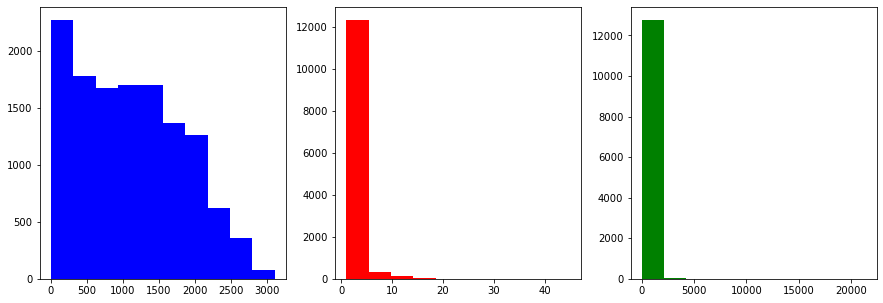

In [577]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].hist(rfm_km['Recency'], color='blue')
axes[1].hist(rfm_km['Frequency'], color='red')
axes[2].hist(rfm_km['Monetary'], color='green')
plt.show()

### Standardization

In [578]:
std_scaler = preprocessing.StandardScaler()
std_rfm = std_scaler.fit_transform(rfm_km)
std_rfm = pd.DataFrame(std_rfm, columns=rfm_km.columns)
std_rfm

,Recency,Frequency,Monetary
0,-1.517677,-0.371483,-0.040975
1,-1.517677,-0.371483,-0.335166
2,-1.516301,-0.371483,0.467084
3,-1.516301,-0.371483,-0.358049
4,-1.516301,-0.371483,-0.205202
...,...,...,...
12824,2.712088,-0.371483,-0.304386
12825,2.721723,-0.371483,-0.364965
12826,2.738240,-0.371483,-0.250919
12827,2.745122,-0.371483,-0.287953


In [579]:
kmeans = KMeans(n_clusters=k, random_state=seed).fit(std_rfm)

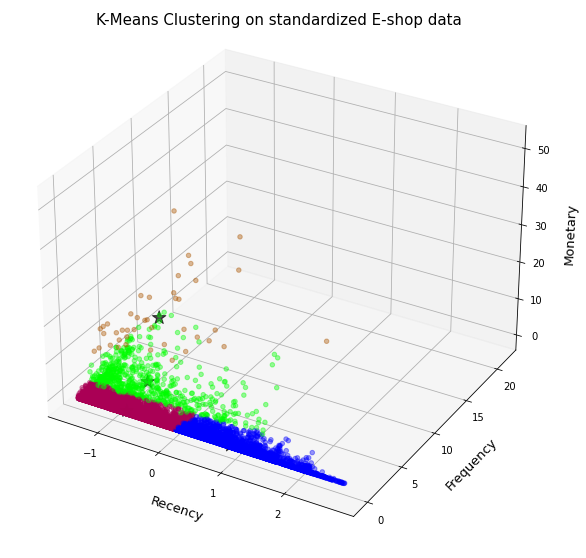

In [580]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(std_rfm['Recency'], std_rfm['Frequency'], std_rfm['Monetary'], c=kmeans.labels_, cmap='brg', alpha=0.4)
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2],
            c='black', alpha=0.7, s=200, marker='*')

ax.set_title('K-Means Clustering on standardized E-shop data', fontsize=15, y=1.04)
ax.set_xlabel('Recency', fontsize=13, labelpad=10)
ax.set_ylabel('Frequency', fontsize=13, labelpad=10)
ax.set_zlabel('Monetary', fontsize=13, labelpad=10)
plt.show()

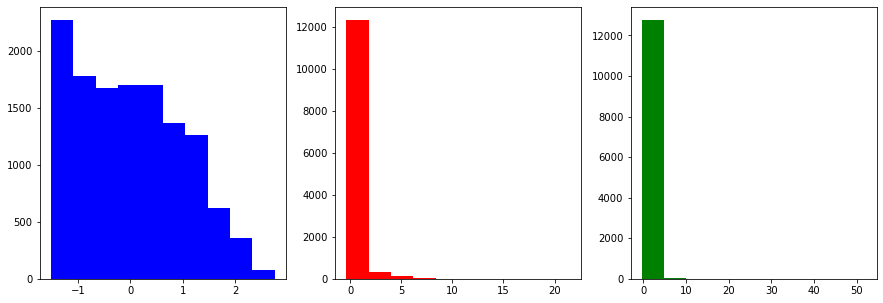

In [581]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].hist(std_rfm['Recency'], color='blue')
axes[1].hist(std_rfm['Frequency'], color='red')
axes[2].hist(std_rfm['Monetary'], color='green')
plt.show()

In [582]:
minmax_scaler = preprocessing.MinMaxScaler()
norm_rfm = minmax_scaler.fit_transform(rfm_km)
norm_rfm = pd.DataFrame(norm_rfm, columns=rfm_km.columns)
norm_rfm

,Recency,Frequency,Monetary
0,0.000000,0.0,0.006448
1,0.000000,0.0,0.000840
2,0.000322,0.0,0.016131
3,0.000322,0.0,0.000404
4,0.000322,0.0,0.003317
...,...,...,...
12824,0.990332,0.0,0.001427
12825,0.992588,0.0,0.000272
12826,0.996455,0.0,0.002446
12827,0.998066,0.0,0.001740


### Normalization

In [583]:
kmeans = KMeans(n_clusters=k, random_state=seed).fit(norm_rfm)

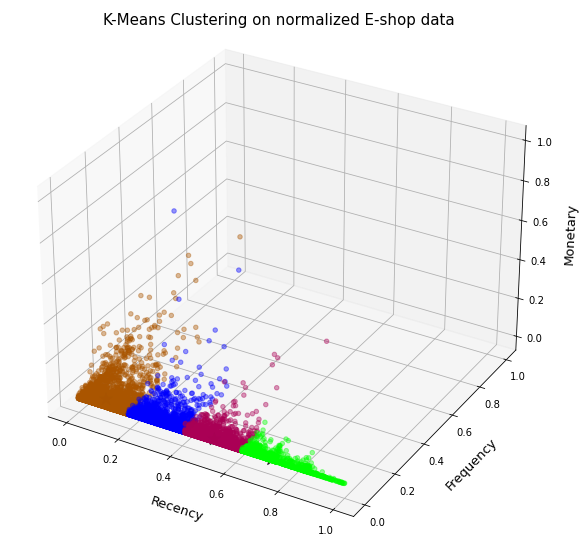

In [584]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(norm_rfm['Recency'], norm_rfm['Frequency'], norm_rfm['Monetary'], c=kmeans.labels_, cmap='brg', alpha=0.4)
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2],
            c='black', alpha=0.7, s=200, marker='*')

ax.set_title('K-Means Clustering on normalized E-shop data', fontsize=15, y=1.04)
ax.set_xlabel('Recency', fontsize=13, labelpad=10)
ax.set_ylabel('Frequency', fontsize=13, labelpad=10)
ax.set_zlabel('Monetary', fontsize=13, labelpad=10)
plt.show()

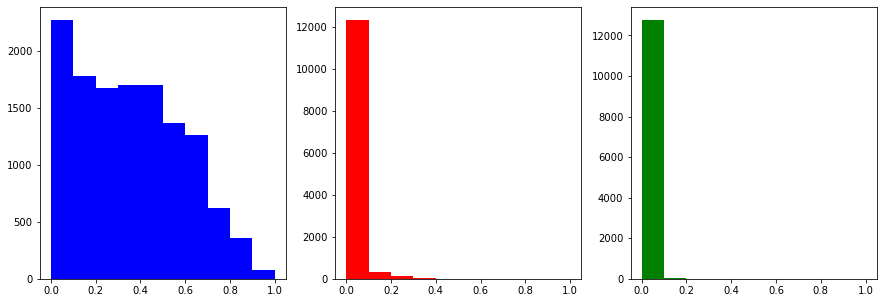

In [585]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].hist(norm_rfm['Recency'], color='blue')
axes[1].hist(norm_rfm['Frequency'], color='red')
axes[2].hist(norm_rfm['Monetary'], color='green')
plt.show()